# Decay Epsilon Greedy Strategy

Early on we can explore the most, when the agent hasn’t experienced the environment enough; later we want the agent to exploit more and more, as it obtains better estimates of the value functions.

In [1]:
import numpy as np

class BanditEnv:
    def __init__(self):
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [2]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # draw a random number and compare to a hyperparameter epsilon
        if np.random.uniform() > epsilon:
            # if it is greater than epsilon, exploit:
            action = np.argmax(Q)
        else:
            # otherwise, explore:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return returns, Qe, actions

In [4]:
def decay_epsilon_greedy(env, init_epsilon=1.0, 
                         min_epsilon=0.01, decay_ratio=0.05, 
                         n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    # Calculate the exponentially decaying epsilons. 
    # Notice we can calculate all of these values at once, 
    # and only query an array of pre-computed values in the loop
    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    
    for e in range(n_episodes):
        
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [12]:
from tqdm import tqdm

returns_epsilon_01 = []
returns_epsilon_001 = []
returns_epsilon_decay = []

envs = []
for i in range(2000):
    envs.append(BanditEnv());

for i in tqdm(range(2000), desc='Running epsilon greedy 0.1'):
    returns, _, _ = epsilon_greedy(env=envs[i], epsilon=0.1)
    returns_epsilon_01.append(returns); 

for i in tqdm(range(2000), desc='Running epsilon greedy 0.01'):
    returns, _, _ = epsilon_greedy(env=envs[i], epsilon=0.01)
    returns_epsilon_001.append(returns);

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _, _ = decay_epsilon_greedy(env=envs[i])
    returns_epsilon_decay.append(returns); 

returns_epsilon_01 = np.array(returns_epsilon_01)
returns_epsilon_001 = np.array(returns_epsilon_001)
returns_epsilon_decay = np.array(returns_epsilon_decay)

Running epsilon decay: 100%|██████████| 2000/2000 [00:06<00:00, 317.10it/s]


In [13]:
# Average reward
avg_reward_epsilon_01 = np.average(returns_epsilon_01, axis=0)
avg_reward_epsilon_001 = np.average(returns_epsilon_001, axis=0)
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)

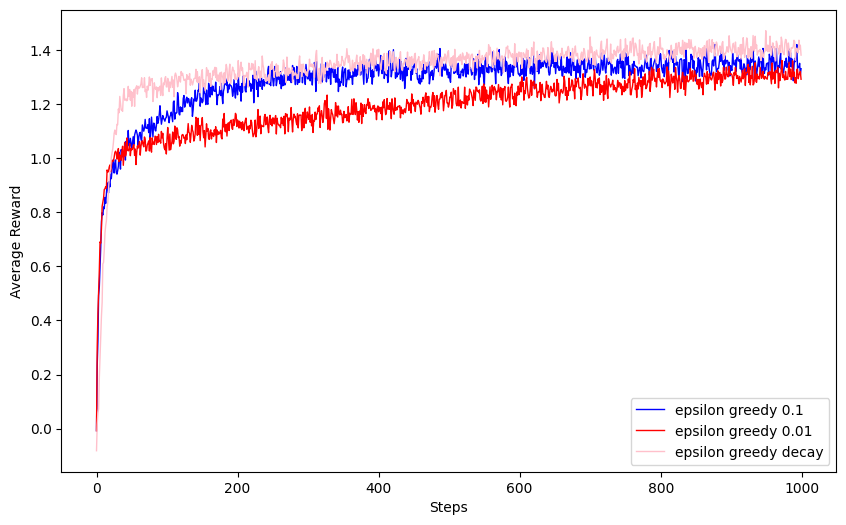

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(avg_reward_epsilon_01,  linewidth=1, color='blue',  label='epsilon greedy 0.1')
plt.plot(avg_reward_epsilon_001, linewidth=1, color='red',   label='epsilon greedy 0.01')
plt.plot(avg_reward_epsilon_decay, linewidth=1, color='pink',   label='epsilon greedy decay')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()